In [1]:
import torch
import torch.nn as nn

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # 어휘 개수
    "context_length": 1024,  # 컨텍스트 길이
    "emb_dim": 768,          # 임베딩 차원
    "n_heads": 12,           # 어텐션 헤드 수
    "n_layers": 12,          # 트랜스포머 블럭 수
    "drop_rate": 0.1,        # 드롭아웃 비율
    "qkv_bias": False        # Query-Key-Value 레이어의 바이어스 사용 여부
}


In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
              for _ in range(cfg["n_layers"])
            ])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self,x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x


In [4]:
import tiktoken

In [5]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)


Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [7]:
#레이어 정규화를 통해 레이어의 여섯 개 출력(활성화)이 평균 0, 분산 1로 정규화되는 과정
torch.manual_seed(123)
batch_example = torch.randn(2, 5)     #1
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)
#1 다섯 차원(특징)을 가진 두 개의 훈련 예제를 생성

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
#keepdim=True 옵션을 사용하면, 평균이나 분산 계산을 할 때 입력 텐서와 동일한 차원을 유지
#dim 파라미터의 사용 예시. 2차원 텐서(매트릭스)에서 dim=0은 행을 따라 수직으로 계산을 수행
#dim=1 또는 dim=-1은 열을 따라 수평으로 계산을 수행
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [9]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
#평균값은 정확하게 0이 아니라 0에 가까움.
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        #eps는 분산을 계산할 때 0으로 나누는 것을 방지하기 위한 작은 상수
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [11]:
shift = nn.Parameter(torch.ones(6))

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
# 배치 정규화
batch_norm = nn.BatchNorm1d(128)
input_data = torch.randn(32, 10, 128)
output = batch_norm(input_data.view(-1, 128)).view(32, 10, 128)

In [14]:
output

tensor([[[-0.3397, -2.3453, -0.8605,  ..., -0.0711, -0.5448,  0.2233],
         [-0.3195,  0.7606,  0.5951,  ..., -1.4343, -0.2171, -1.4330],
         [ 0.1684, -0.7851,  0.6169,  ...,  1.1216, -0.4468,  0.8149],
         ...,
         [ 0.8165, -0.1474,  2.2680,  ..., -0.0432, -1.9578,  0.7767],
         [ 0.5767,  0.7123,  0.2469,  ..., -0.1356,  0.2980,  0.1371],
         [-1.8917,  0.2867, -0.5463,  ...,  0.5385, -2.2097,  0.8096]],

        [[ 0.8657, -0.4449, -0.8746,  ...,  0.0630, -1.5567,  0.3531],
         [-0.7195, -0.9594, -0.7872,  ..., -0.6646, -1.1125, -0.1751],
         [ 0.7149, -1.2321, -0.5341,  ...,  0.3598,  0.1370,  0.5411],
         ...,
         [ 0.4557,  0.7597, -1.7178,  ...,  1.4296,  1.1494, -0.2712],
         [ 1.1831,  0.1508,  0.5671,  ...,  0.5754,  0.3558, -0.0843],
         [-0.6465,  1.2306,  1.7140,  ...,  0.5245,  0.2985, -0.7215]],

        [[-0.0226, -1.0585, -0.2310,  ..., -0.6487, -0.5211,  0.4987],
         [ 1.0421, -1.4149,  0.8045,  ..., -0

In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

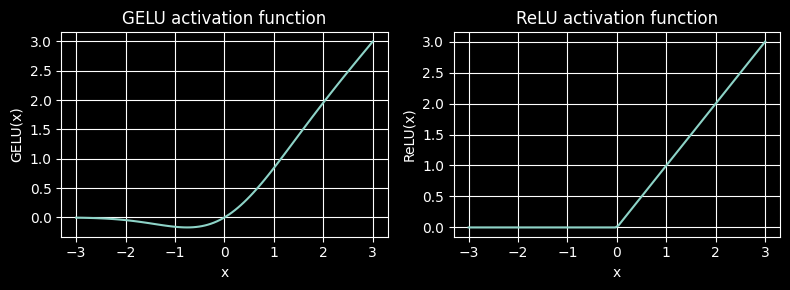

In [16]:
import matplotlib.pyplot as plt
import numpy as np

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)  
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [18]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [19]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        # use_shortcut은 네트워크에서 잔차 연결(shortcut connection)을 사용할지 여부를 결정하는 플래그
        self.use_shortcut = use_shortcut
        # 네트워크의 각 층을 nn.ModuleList에 저장. 각 층은 nn.Sequential을 사용해 선형 레이어와 GELU 활성화 함수로 구성됨
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                          GELU())
        ])

    def forward(self, x):
        # 각 레이어를 순차적으로 거치며 데이터를 처리
        for layer in self.layers:
            layer_output = layer(x) 
            # use_shortcut이 True이고, 입력 x와 layer_output의 shape이 동일한 경우에만 잔차 연결 적용
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [20]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [21]:
def print_gradients(model, x):
    output = model(x)
    # 목표(target)값을 0으로 설정, 예를 들어 회귀 문제에서 목표값이 0인 경우
    target = torch.tensor([[0.]])
    # 손실 함수로 평균 제곱 오차(MSE)를 사용
    loss = nn.MSELoss()
    loss = loss(output, target)    
    # 모델 출력값과 목표값 간의 손실을 계산
    loss.backward()          

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 각 weight 파라미터의 절대값을 취한 후 그 평균값을 출력
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [22]:
print_gradients(model_without_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [25]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
'''
마지막 레이어(layers.4)는 여전히 다른 레이어들보다 더 큰 기울기를 가지고 있지만, 
첫 번째 레이어(layers.0)로 갈수록 기울기 값이 안정화되며 매우 작은 값으로 줄어들지는 않으ㅁ
결론적으로, 딥러닝 신경망에서 기울기 소실 문제를 극복하기 위해서는 잔차 연결(shortcut connections)이 중요함
잔차 연결은 LLM의 핵심 구성 요소이며, GPT 모델을 훈련할 때 각 레이어에서 일관된 기울기 흐름을 보장하여 더 효과적인 훈련을 가능하게 힘.
'''
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [26]:
#ToDo) 레이어 정규화, GELU 활성화 함수, 피드포워드 모듈, 잔차 연결을 트랜스포머 블록과 연결